In [1]:
import re
import xapian
import pandas as pd
import numpy as np
import csv

In [2]:
import json

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
pd.options.display.max_colwidth = 200
pd.options.display.precision = 2

In [5]:
DBPATH = "ner_index"
SOURCES = ['dev', 'train', 'test']
SOURCES = ['dev']
SEARCH_RESULT_PATH = "data/search_results_v2.1.csv"

In [6]:
!xapian-delve $DBPATH

UUID = 264d9bea-55c9-4caf-9979-abe630f0809a
number of documents = 5365408
average document length = 178.465
document length lower bound = 1
document length upper bound = 68701
highest document id ever used = 5365408
has positional information = true
revision = 537
currently open for writing = false


In [7]:
!xapian-delve -r 40000 -d $DBPATH

Data for record #40000:
{"doc_id": "1992_Los_Angeles_Raiders_season", "shard": "001", "text": "The 1992 Los Angeles Raiders season was their 33rd in the National Football League -LRB- NFL -RRB- . They were unable to improve upon their previous season 's output of 9 -- 7 , winning only seven games . This was the first time in three seasons the team failed to qualify for the playoffs .", "keywords": ["33rd", "Los Angeles Raiders", "the National Football League", "1992", "NFL", "Raiders", "League", "season", "The 1992 Los Angeles Raiders season", "(NFL"]}
Term List for record #40000: 1992 33rd 7 9 K(nfl K1992 K33rd Kleague Klos angeles raiders Knfl Kraiders Kseason Kthe 1992 los angeles raiders season Kthe national football league Q1992_Los_Angeles_Raiders_season Zangel Zfail Zfirst Zfootbal Zfor Zgame Zimprov Zin Zleagu Zlos Zlrb Znation Znfl Zof Zonli Zoutput Zplayoff Zprevious Zqualifi Zraider Zrrb Zs Zseason Zseven Zteam Zthe Ztheir Zthey Zthis Zthree Ztime Zto Zunabl Zupon Zwas Zwere

# Retrieve documents relevant to claims

In [107]:
import spacy
import en_core_web_lg

nlp = en_core_web_lg.load()
def parse_with_spacy(text):
    doc = nlp(text)
    record = dict(
        named_entities = [{'entity': span.text, 'label': span.label_, 'root': span.root.text} for span in doc.ents],
        noun_phrases = [{'noun_phrase': span.text, 'root': span.root.text} for span in doc.noun_chunks]
    )
    return record

def preprocess_ner(s):
    #s = re.sub("^(The|the|A|a|An|an)\s", "", s)
    #s = re.sub("\s", "_", s) 
    return s

def obtain_nouns(v):
    ents = {preprocess_ner(item['entity']) for item in v['named_entities']}
    ents_roots = {preprocess_ner(item['root']) for item in v['named_entities']}
    nps = {preprocess_ner(item['noun_phrase']) for item in v['noun_phrases']}
    nps_roots = {preprocess_ner(item['root']) for item in v['noun_phrases']}
    return ents.union(nps).union(ents_roots).union(nps_roots)
    #return ents_roots.union(nps_roots)

In [108]:
def get_doc_id(match):
    for term in match.document.termlist():
        term = term.term.decode("utf-8") 
        m = re.match("Q(.*)", term)
        if m:
            return m[1]
    return None

In [109]:
# Prepare enquiry object

# Open the database we're going to search.
db = xapian.Database(DBPATH)

# Set up a QueryParser with a stemmer and suitable prefixes
queryparser = xapian.QueryParser()
queryparser.set_stemmer(xapian.Stem("en"))
queryparser.set_stemming_strategy(queryparser.STEM_SOME)
#queryparser.add_prefix('keywords', 'K')

# Use an Enquire object on the database to run the query
enquire = xapian.Enquire(db)    

query = 'keywords:"1992_Los_Angeles_Raiders_season nfl" first time in three seasons the team failed'


query = queryparser.parse_query(query)
print(query)
enquire.set_query(query)
matches = enquire.get_mset(0, pagesize)

query_results = []
for match in matches:
    result = dict(
        claim_id = claim_id,
        found_doc = get_doc_id(match),
        rank = match.rank + 1,
        percentage = match.percent,
        weight = match.weight,            
    )
    query_results.append(result)
query_results

In [110]:
claim_df = pd.read_json('data/claims_lm.json').sort_index()

In [111]:
mask = claim_df.source.isin(SOURCES)
claim_df = claim_df[mask]

In [112]:
from utils import KeywordsAndEntityTask

In [113]:
processor = KeywordsAndEntityTask()

In [114]:
%%time
#claim_df['search_words'] = claim_df.claim.apply(processor.extract_keyword_list)
claim_df['search_words'] = claim_df.claim.apply(parse_with_spacy).apply(obtain_nouns)
#(claim_df.np_phrase + claim_df.np_roots).apply(lambda x: list(np.unique(x)))

CPU times: user 37.7 s, sys: 270 ms, total: 38 s
Wall time: 38 s


In [115]:
claim_df.shape

(5001, 11)

In [116]:
search_column = 'search_words'

In [117]:
%%time
fields = ['claim_id', 'found_doc', 'rank', 'percentage', 'weight']
pagesize = 100
i = 0
results = []

with open(SEARCH_RESULT_PATH, 'w') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=fields)
    writer.writeheader()

    for claim_id, claim, keywords in claim_df[['claim', search_column]].itertuples():
        if i % 1000 == 0:
            print(i // 1000, claim_id)
        i += 1

        #query_str = 'keywords:"{}" {}'.format(" ".join(keywords), claim)
        #query_str = 'keywords:{}'.format(" keywords:".join(keywords))
        #query_str = 'keywords:{}'.format(" keywords:".join(keywords))
        #query_str = " ".join(keywords)
        #query_str = '+({}) {}'.format(" ".join(keywords), claim)
        
        query_str = claim
        query = queryparser.parse_query(query_str)
        
        filter_queries = [xapian.Query(word.lower()) for word in keywords]
        filter_query = xapian.Query(xapian.Query.OP_OR, filter_queries)
        
        query = xapian.Query(xapian.Query.OP_FILTER, query, filter_query)
        
        #print(query)
        enquire.set_query(query)
        matches = enquire.get_mset(0, pagesize)

        query_results = []
        for match in matches:
            result = dict(
                claim_id = claim_id,
                found_doc = get_doc_id(match),
                rank = match.rank + 1,
                percentage = match.percent,
                weight = match.weight,            
            )
            query_results.append(result)
        writer.writerows(query_results)
        results += query_results
csvFile.close()

0 12
1 52175
2 100083
3 144903
4 185736
5 229319
CPU times: user 9min 3s, sys: 1min 57s, total: 11min
Wall time: 11min 40s


# Analyse Found Documents

## Read search results

In [118]:
import unicodedata

In [119]:
results_df = pd.read_csv(SEARCH_RESULT_PATH)
normalise = lambda item: unicodedata.normalize('NFD', item) if isinstance(item, str) else item
results_df['found_doc'] = results_df['found_doc'].apply(normalise)

In [120]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498137 entries, 0 to 498136
Data columns (total 5 columns):
claim_id      498137 non-null int64
found_doc     498137 non-null object
rank          498137 non-null int64
percentage    498137 non-null int64
weight        498137 non-null float64
dtypes: float64(1), int64(3), object(1)
memory usage: 19.0+ MB


In [121]:
#results_df.sort_values('percentage', ascending=False).head(100)
results_df.sort_values('weight', ascending=False).head(10)

,claim_id,found_doc,rank,percentage,weight
224677,111251,Boylston_-LRB-MBTA_station-RRB-,1,97,156.38
50396,26138,Boylston_-LRB-MBTA_station-RRB-,1,100,133.48
224678,111251,Park_Street_-LRB-MBTA_station-RRB-,2,78,126.69
123446,63575,Park_Street_-LRB-MBTA_station-RRB-,1,96,124.92
224679,111251,"Green_Line_""B""_Branch",3,74,119.67
224680,111251,Government_Center_-LRB-MBTA_station-RRB-,4,74,119.20
224681,111251,Hynes_Convention_Center_-LRB-MBTA_station-RRB-,5,72,116.97
153994,77743,List_of_accolades_received_by_Bajirao_Mastani,1,81,111.57
50397,26138,Park_Street_-LRB-MBTA_station-RRB-,2,83,111.04
153995,77743,List_of_accolades_received_by_Queen_-LRB-film-RRB-,2,80,109.67


## Read claims

In [122]:
sources = SOURCES
if 'test' in sources:
    sources.remove('test')
    
labelled_claims_df = pd.read_json('data/l_claims.json').sort_index()
mask = labelled_claims_df.source.isin(sources)
labelled_claims_df = labelled_claims_df[mask]

In [123]:
labelled_claims_df.head()

,claim,evidence,label,source,evidence_docs,evidence_doc_count,evidence_sentence_count,evidence_set_str
12,Carlos Santana disbanded Santana in 1965.,"[[Carlos_Santana, 3], [Carlos_Santana, 0], [Carlos_Santana, 2]]",REFUTES,dev,[Carlos_Santana],1,3,{'Carlos_Santana'}
70,David Packouz was born in February of 1982.,"[[David_Packouz, 0]]",SUPPORTS,dev,[David_Packouz],1,1,{'David_Packouz'}
97,Craig David is a pop music performer.,"[[Craig_David, 2], [Craig_David, 0], [Craig_David, 5]]",SUPPORTS,dev,[Craig_David],1,3,{'Craig_David'}
98,Craig David is a performer that does pop music.,[],NOT ENOUGH INFO,dev,[],0,0,set()
158,Wish Upon was released in France.,[],NOT ENOUGH INFO,dev,[],0,0,set()


## Estimate index-search performance

In [124]:
def calculate_recall(mask):
    func = lambda x: set(x)
    found_docs_df = results_df[mask].pivot_table(index='claim_id', values='found_doc', aggfunc=func)

    recall_df = labelled_claims_df[['evidence_docs', 'source', 'claim']].join(found_docs_df)

    def func(x):
        if isinstance(x['found_doc'], set):
            return set(x['evidence_docs']).difference(x['found_doc'])
        return set(x['evidence_docs'])

    recall_df['missed_docs'] = recall_df.apply(func, axis=1)
    recall_df['missed_count'] = recall_df['missed_docs'].apply(len)

    recall_df = recall_df.pivot_table(index='missed_count', columns='source',# margins=True,
                                                    values='claim', aggfunc='count', fill_value=0)
    return recall_df

In [125]:
%%time

results = []
for top in range(5, 101, 5):
    #print(top)
    mask = results_df['rank'] <= top
    
    recall_df = calculate_recall(mask)
    
    recall_df = (recall_df / recall_df.sum() * 100).head(1)
    recall_df['top'] = top
    results += recall_df.to_dict(orient="records")

CPU times: user 10.8 s, sys: 591 ms, total: 11.4 s
Wall time: 11.4 s


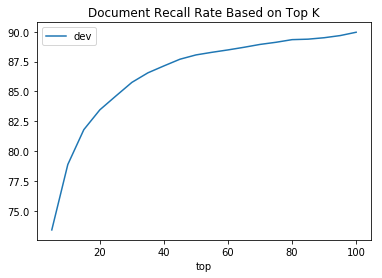

,dev
top,
5.0,73.41
10.0,78.88
15.0,81.80
20.0,83.46
25.0,84.62
30.0,85.76
35.0,86.56
40.0,87.14
45.0,87.70


In [126]:
df = pd.DataFrame.from_records(results).set_index('top')
df.plot.line(title='Document Recall Rate Based on Top K')
plt.show()
df#.T

In [127]:
%%time

results = []
for top in range(5, 101, 5):
    #print(top)
    mask = results_df['percentage'] >= top
    
    recall_df = calculate_recall(mask)

    recall_df = (recall_df / recall_df.sum() * 100).head(1)
    recall_df['percentage'] = top
    results += recall_df.to_dict(orient="records")

CPU times: user 9.21 s, sys: 510 ms, total: 9.72 s
Wall time: 9.63 s


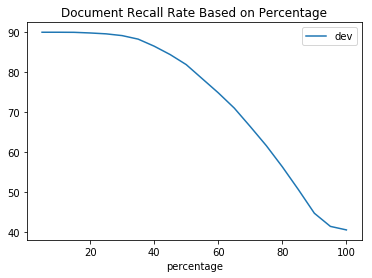

,dev
percentage,
5.0,89.96
10.0,89.96
15.0,89.94
20.0,89.78
25.0,89.56
30.0,89.12
35.0,88.24
40.0,86.48
45.0,84.38


In [128]:
df = pd.DataFrame.from_records(results).set_index('percentage')
df.plot.line(title='Document Recall Rate Based on Percentage')
plt.show()
df#.T

In [129]:
%%time

results = []
for top in range(10, 25, 1):
    #print(top)
    mask = results_df['weight'] >= top
    
    recall_df = calculate_recall(mask)

    recall_df = (recall_df / recall_df.sum() * 100).head(1)
    recall_df['weight'] = top
    results += recall_df.to_dict(orient="records")

CPU times: user 8.03 s, sys: 486 ms, total: 8.52 s
Wall time: 8.43 s


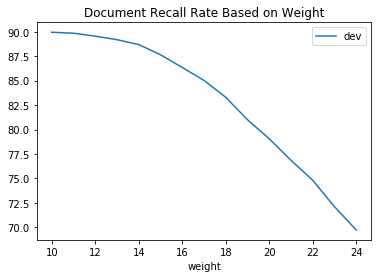

,dev
weight,
10.0,89.94
11.0,89.84
12.0,89.54
13.0,89.18
14.0,88.68
15.0,87.64
16.0,86.34
17.0,85.02
18.0,83.30


In [130]:
df = pd.DataFrame.from_records(results).set_index('weight')
df.plot.line(title='Document Recall Rate Based on Weight')
plt.show()
df#.T

## Search performance with filters applied

In [131]:
mask = (results_df['rank'] <= 10) #& (results_df.weight > 10) #& (results_df.percentage > 25)
recall_df = calculate_recall(mask)
recall_df = (recall_df / recall_df.sum() * 100)#.head(1)
recall_df.head(1)

source,dev
missed_count,
0,78.88


In [132]:
results_df.found_doc.unique().shape[0], results_df[mask].found_doc.unique().shape[0] 

(252094, 25227)

In [133]:
mask = (results_df['rank'] <= 25)
processed_docs = results_df[mask].found_doc.unique()
len(processed_docs)

63602

In [134]:
mask = (results_df['rank'] <= 50)
docs = results_df[mask].found_doc.unique()
len(docs)

127548

In [135]:
docs = list(set(docs).difference(set(processed_docs)))
len(docs)

63946

In [136]:
with open('data/top_26-50_docs.json', 'w') as fp:
    json.dump(list(docs), fp)

## Prepare submission

In [104]:
mask = (results_df['rank'] <= 10) & (results_df.percentage > 25) & (results_df.weight > 15)
submission_df = results_df[mask].set_index('claim_id')[['found_doc']].join(claim_df.claim)
submission_df.head()

,found_doc,claim
12,Santana_-LRB-surname-RRB-,Carlos Santana disbanded Santana in 1965.
12,Carlos_Santana_-LRB-disambiguation-RRB-,Carlos Santana disbanded Santana in 1965.
12,Jorge_Santana,Carlos Santana disbanded Santana in 1965.
12,Santana_-LRB-band-RRB-,Carlos Santana disbanded Santana in 1965.
12,Santana,Carlos Santana disbanded Santana in 1965.


In [105]:
results_df.shape, submission_df.shape,

((460866, 5), (41545, 2))

In [106]:
results_df.head()

,claim_id,found_doc,rank,percentage,weight
0,12,Santana_-LRB-surname-RRB-,1,66,39.37
1,12,Carlos_Santana_-LRB-disambiguation-RRB-,2,64,37.93
2,12,Jorge_Santana,3,63,37.41
3,12,Santana_-LRB-band-RRB-,4,62,36.77
4,12,Santana,5,61,36.61


In [74]:
results_df.found_doc.unique().shape, submission_df.found_doc.unique().shape

((238325,), (23767,))

In [75]:
submission_df['label'] = "SUPPORTS"
submission_df['evidence'] = submission_df.found_doc.apply(lambda x: [[x, 0]])

In [76]:
del submission_df['found_doc']

In [77]:
#submission_df.to_json('testoutput.json', orient='index')

In [78]:
submission_df.shape

(49557, 3)

## Evidence found

In [79]:
found_docs_df = results_df.pivot_table(index='claim_id', values='found_doc', aggfunc=list)
recall_df = labelled_claims_df[['evidence_docs', 'source', 'claim']].join(found_docs_df)

def func(x):
    if isinstance(x['found_doc'], list):
        return set(x['evidence_docs']).difference(set(x['found_doc']))
    return set(x['evidence_docs'])

recall_df['missed_docs'] = recall_df.apply(func, axis=1)
recall_df['missed_count'] = recall_df['missed_docs'].apply(len)

In [80]:
recall_df[recall_df.missed_count > 0]

,evidence_docs,source,claim,found_doc,missed_docs,missed_count
455,"[Sheryl_Lee, Café_Society_-LRB-film-RRB-]",dev,Sheryl Lee appeared in an American romantic comedy-drama film.,"[Rain_-LRB-TV_series-RRB-, Hope_Springs, Amanda_Peet, The_Best_Man_-LRB-1999_film-RRB-, Curtis_Hanson, Bombshell_-LRB-film-RRB-, Celeste_and_Jesse_Forever, Julia_Roberts_filmography, Margot_Robbie...",{Café_Society_-LRB-film-RRB-},1
673,[Saxony],dev,Saxony is only a town.,"[List_of_cities_and_towns_in_Germany, Langendorf, Ebersbach, Seehausen,_Börde, Loburg, Radegast, Jeßnitz, Würchwitz, Raguhn, Ohre, Oberharz_am_Brocken, Glinde,_Saxony-Anhalt, Roitzsch, Strahwald...",{Saxony},1
752,"[Tottenham_Hotspur_F.C., EFL_Cup, FA_Cup]",dev,Tottenham Hotspur F.C. is a football club.,"[Tottenham_Hotspur_L.F.C., History_of_Tottenham_Hotspur_F.C., Bobby_Buckle, List_of_Tottenham_Hotspur_F.C._players, Tottenham_Hotspur_-LRB-Superleague_Formula_team-RRB-, Hotspur, Lilywhites, Totte...","{FA_Cup, Tottenham_Hotspur_F.C., EFL_Cup}",3
1076,"[James_Jones_-LRB-basketball_player-RRB-, NBA_playoffs]",dev,James Jones missed the finals once.,"[James_Jones_-LRB-basketball_player-RRB-, The_Vessel_of_Wrath, List_of_United_Kingdom_MPs-COLON-_J, Phalon_Jones, Lewis_Jones_-LRB-bishop-RRB-, Isaac_Jones_-LRB-sprinter-RRB-, 1905_Open_Championsh...",{NBA_playoffs},1
1831,[DNA_-LRB-Little_Mix_album-RRB-],dev,DNA is a single.,"[Single_molecule_real_time_sequencing, Hyperchromicity, Mung_bean_nuclease, DNA_virus, DNA_ligase, Single-strand_DNA-binding_protein, Aspergillus_nuclease_S1, DNA_polymerase, Replication_protein_A...",{DNA_-LRB-Little_Mix_album-RRB-},1
2421,"[Tualatin_River, Beaverton,_Oregon]",dev,"Beaverton, Oregon's city center is in the Grand Canyon.","[Tualatin_Valley_Highway, Beaverton_High_School, Beaverton,_Oregon, Grand_Canyon_Airlines, Wilsonville_Station, Canyon_Road, Washington_Square_Transit_Center, Beaverton_Transit_Center, Tualatin_Hi...",{Tualatin_River},1
5454,[Jack_Falahee],dev,Jack Falahee's middle name is Bryan.,"[Bryan_Creed_Jack, Jack_Bryan, Long_Middle_School, John_Bryan, Bryan_County,_Georgia, 2015_Miami_Open_–_Men's_Doubles, 2015_BNP_Paribas_Masters_–_Doubles, Intent_to_Kill, Thatcher_Unified_School_D...",{Jack_Falahee},1
5766,[Hot_Right_Now],dev,Hot Right Now is from the author Bob Stanley.,"[Robert_Stanley, Bob_Wilson_-LRB-cartoonist-RRB-, If_Looks_Could_Kill_-LRB-Heart_song-RRB-, Candy_Girl_-LRB-The_Four_Seasons_song-RRB-, Troy_Stanley, Robert_Parr_-LRB-disambiguation-RRB-, James_Bo...",{Hot_Right_Now},1
6683,"[2012_San_Francisco_49ers_season, Colin_Kaepernick]",dev,Colin Kaepernick is a starter for the San Francisco 49ers.,"[Colin_Kaepernick, 2016_San_Francisco_49ers_season, 2016_U.S._national_anthem_protests, 2014_San_Francisco_49ers_season, 49ers–Seahawks_rivalry, Alex_Smith, 1981_Atlanta_Falcons_season, Colin_Cloh...",{2012_San_Francisco_49ers_season},1
7013,"[Penélope_Cruz, Mango_-LRB-clothing-RRB-]",dev,Penélope Cruz has modeled for the clothing company Mango.,"[Sessions_-LRB-clothing_company-RRB-, Mango_-LRB-clothing-RRB-, Carolina_Engman, Ice_cream_-LRB-disambiguation-RRB-, Nuclear_Mango, Apranga, Shezan_International, Lagunas,_Oaxaca, Edwin_-LRB-compa...",{Penélope_Cruz},1


In [81]:
found_df.evidence_docs.astype(str).value_counts().to_frame()

NameError: name 'found_df' is not defined

## Evidence missed

In [ ]:
missed_df = labelled_claims_df[labelled_claims_df.missed_count > 0]

In [ ]:
missed_df = missed_df.join(claim_df[['named_entities', 'np_phrase']])

In [ ]:
cols = ['claim', 'named_entities', 'np_phrase', 'evidence_docs',
       'evidence_doc_count', 'found_doc', 'missed_docs', 'missed_count']
missed_df.sort_values(['missed_count', 'evidence_set_str'], ascending=[False, True])[cols].head(100)

In [ ]:
missed_df.missed_docs.astype(str).value_counts().to_frame()